In [ ]:
!pip install cmapPy

In [ ]:
!pip install gsva

## Imports

In [ ]:
import numpy as np
import pandas as pd
import cmapPy.pandasGEXpress.parse as cmapPandas
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,StandardScaler
import plotly.graph_objects as go
import plotly.offline as pyo
from GSVA import gsva
from plotnine import *
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

In [ ]:
!unzip data_analyst_intern-20201121T181639Z-001.zip

Archive:  data_analyst_intern-20201121T181639Z-001.zip
replace data_analyst_intern/type1_IFN.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data_path = "./data_analyst_intern/PAAD.gct"

In [ ]:
#gct file contains col meta data and row meta data
dataset = cmapPandas.parse(data_path)
row_meta_data = dataset.row_metadata_df
col_meta_data = dataset.col_metadata_df
data = dataset.data_df

> File type is GCT(.gct) :- 
> Which is a tab-delimited text file that contains gene expression data.

>It has three dataframes these are

1. **data** - It has 18465 rows (Gene ID) abd 183 columns (Samples)
2. **col_meta_data** - It has 183 columns (Sample Names/ID) and 124 rows (Column metadata like histological_type, Patient_ID, status(is he alive or not)) for each sample.- 
3. **row_meta_data** - It has row metadata and When we see the type, It is empty dataframe. This means in our data, the row metadata is not present.

## Exploring Dataset

In [ ]:
#dataset info
row_meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18465 entries, SLC35E2 to psiTPTE22
Empty DataFrame

In [ ]:
col_meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
Columns: 124 entries, participant_id to year_of_tobacco_smoking_onset
dtypes: float64(49), int64(10), object(65)
memory usage: 183.7+ KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18465 entries, SLC35E2 to psiTPTE22
Columns: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
dtypes: float32(183)
memory usage: 13.7+ MB


In [ ]:
row_meta_data.head()

Empty DataFrame
Columns: []
Index: [SLC35E2, A1BG, A1CF, A2BP1, A2LD1]

In [ ]:
col_meta_data.head()

chd                      participant_id  ... year_of_tobacco_smoking_onset
cid                                      ...                              
aab1-Primary solid Tumor           aab1  ...                        1962.0
aab4-Primary solid Tumor           aab4  ...                           NaN
aab6-Primary solid Tumor           aab6  ...                           NaN
aab8-Primary solid Tumor           aab8  ...                           NaN
aab9-Primary solid Tumor           aab9  ...                           NaN

[5 rows x 124 columns]

In [ ]:
data.head()

cid      aab1-Primary solid Tumor  ...  aapl-Primary solid Tumor
rid                                ...                          
SLC35E2                      7.45  ...                      9.05
A1BG                         6.40  ...                      6.90
A1CF                         4.70  ...                      2.00
A2BP1                       -1.00  ...                       NaN
A2LD1                        7.50  ...                      6.70

[5 rows x 183 columns]

In [ ]:
col_meta_data.shape

(183, 124)

1. As we can see there are a lot of columns in the col_meta_data part
2. As if columns contains constant values that is of no use we need to find if there are any columns that contains contant values we can drop them and not take them into consideration

In [ ]:
#As we can see there are a lot of columns in the col_meta_data part
#As if columns contains constant values that is of no use we need to find if there are any columns that contains contant values we can drop them and not take them into consideration

In [ ]:
def findUniqueCols(data):
  arr = []
  for col in data.columns:
    if len(data[col].unique())<2:
      arr.append(col)
  print("Number of columns with constant values "+str(len(arr)))
  return arr

In [ ]:
def dropConstCols(data):
  col_list = findUniqueCols(data)
  data = data.drop(col_list,axis=1)
  return data

In [ ]:
#give some showcase
#drop columns which have unique values
col_meta_data = dropConstCols(col_meta_data)

Number of columns with constant values 41


In [ ]:
col_meta_data.shape

(183, 83)

In [ ]:
#rid gives us the types of RNA sequence
row_meta_data.shape

(18465, 0)

>There are 18465 types of rna sequence

### There are many missing values in the dataset we can use a imputer to replace the values or we can drop the values

### A. By droping the values

In [ ]:
new_data = data.dropna()
np_arry = new_data.values.T

In [ ]:
scaler = StandardScaler()
np_arry = scaler.fit_transform(np_arry)

In [ ]:
pca = PCA(n_components=2)
y = pca.fit_transform(np_arry)

In [ ]:
def variancePCAPlot(pca,n_components):
  cumulative_variance_ratio = (pca.explained_variance_ratio_.cumsum())*100

  explained_variance_ratio = round(pca.explained_variance_ratio_.sum()*100, 2)

  plt.bar(range(n_components), cumulative_variance_ratio, label='Cumulative Sum of Explained Varaince Ratio')
  plt.title(f"{explained_variance_ratio}% of variance is explained by the fisrt {n_components} principle component ");

  print("Explained Variance Ratio--")
  print(pca.explained_variance_ratio_)
  print("################################")

Explained Variance Ratio--
[0.16429959 0.11939825]
################################


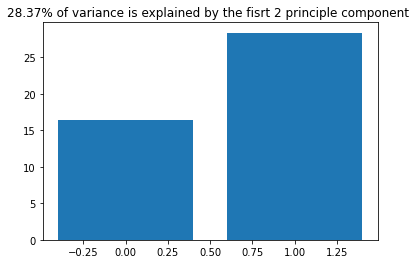

In [ ]:
variancePCAPlot(pca,2)

>Using PCA to sort out two different cluster points for Exocrine and Neuroendocrine pancreatic cancerm

In [ ]:
c = ["violet", "brown","lightblue", "orange","purple","black","crimson","maroon","darkgreen", "deeppink", "royalblue","lightyellow", "orange", "darkred", "darkgray"]
histological_data = [str(i) for i in list(col_meta_data['histological_type_other'].unique())]
c_dict = dict()
for l, c in zip(histological_data, c):
    c_dict[l] = c
labels = [c_dict[str(i)] for i in list(col_meta_data['histological_type_other'])]

Text(0, 0.5, 'PC2')

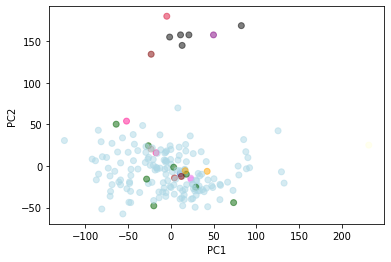

In [ ]:
plt.scatter(y[:,0], y[:,1],c=labels,alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")

From this we can clearly see that most of the points are concentrated in one cluster and very few point are in the second cluser and this also verifyies the information available for these types of cancer as the Neuroendocrine tumors are rare as compared to the exocrine turmors which are most common.

> We can also say that exocrine are the ones with PC1<100 and PC1>-100 or PC2<50 others ones are outliers and we can say that they are the neuroendocrine ones

In [ ]:
pca_df = pd.DataFrame(y, columns=['PC1', 'PC2'], index=new_data.columns.values)
pca_df.head()

PC1        PC2
aab1-Primary solid Tumor  23.225252 -14.563457
aab4-Primary solid Tumor   4.242111 -14.212588
aab6-Primary solid Tumor  28.721029 -27.624355
aab8-Primary solid Tumor  -0.725019 -24.624269
aab9-Primary solid Tumor   0.321680   2.133416

In [ ]:
neuroendocrine_tumors = pca_df[(pca_df['PC1'] < -100) | (pca_df['PC1'] > 100) | (pca_df['PC2'] > 50)].index
print(neuroendocrine_tumors)
print("Number of Neuroendocrine Tumors:"+str(len(neuroendocrine_tumors)))

Index(['aabv-Primary solid Tumor', 'aaqm-Primary solid Tumor',
       'a9ij-Primary solid Tumor', 'a9il-Primary solid Tumor',
       'a9in-Primary solid Tumor', 'a9io-Primary solid Tumor',
       'a9ir-Primary solid Tumor', 'a9is-Primary solid Tumor',
       'a9iv-Primary solid Tumor', '6880-Primary solid Tumor',
       'a45n-Solid Tissue Normal', 'a7ol-Primary solid Tumor',
       'a7op-Primary solid Tumor', '8519-Primary solid Tumor',
       '7897-Primary solid Tumor', 'a75w-Primary solid Tumor'],
      dtype='object')
Number of Neuroendocrine Tumors:16


> Dropping the Neuroendocrine Tumors from our dataset

In [ ]:
pca_df = pca_df.drop(neuroendocrine_tumors)

In [ ]:
new_data.head()

cid      aab1-Primary solid Tumor  ...  aapl-Primary solid Tumor
rid                                ...                          
SLC35E2                      7.45  ...                      9.05
A1BG                         6.40  ...                      6.90
A2LD1                        7.50  ...                      6.70
A2M                         14.30  ...                     13.30
A4GALT                      10.60  ...                      9.00

[5 rows x 183 columns]

In [ ]:
ifn_data = pd.read_csv("./data_analyst_intern/type1_IFN.txt",header=None)

In [ ]:
arr = []
for i in ifn_data.values:
  v = i.tolist()
  arr.append(v[0])
arr.remove("IRGM")

In [ ]:
ifn_df = new_data.loc[arr]

In [ ]:
ifn_df.head()

cid    aab1-Primary solid Tumor  ...  aapl-Primary solid Tumor
rid                              ...                          
IFIT1                       9.5  ...                      10.2
IFI44                       9.4  ...                      10.9
IFIT3                      10.0  ...                      10.2
MX2                         9.8  ...                      10.9
OAS1                       11.7  ...                      10.7

[5 rows x 183 columns]

In [ ]:
ifn_df.shape

(24, 183)

In [ ]:
ifn_df = ifn_df.drop(neuroendocrine_tumors,axis=1)

In [ ]:
ifn_df.shape

(24, 167)

## Distribution of 24 genes i.e the IFN signature

In [ ]:
configure_plotly_browser_state()

pyo.init_notebook_mode()

fig = go.Figure(data=go.Heatmap(
                   z=ifn_df.values,
                   x=ifn_df.columns,
                   y=ifn_df.index,
                   hoverongaps = False))
fig.show()

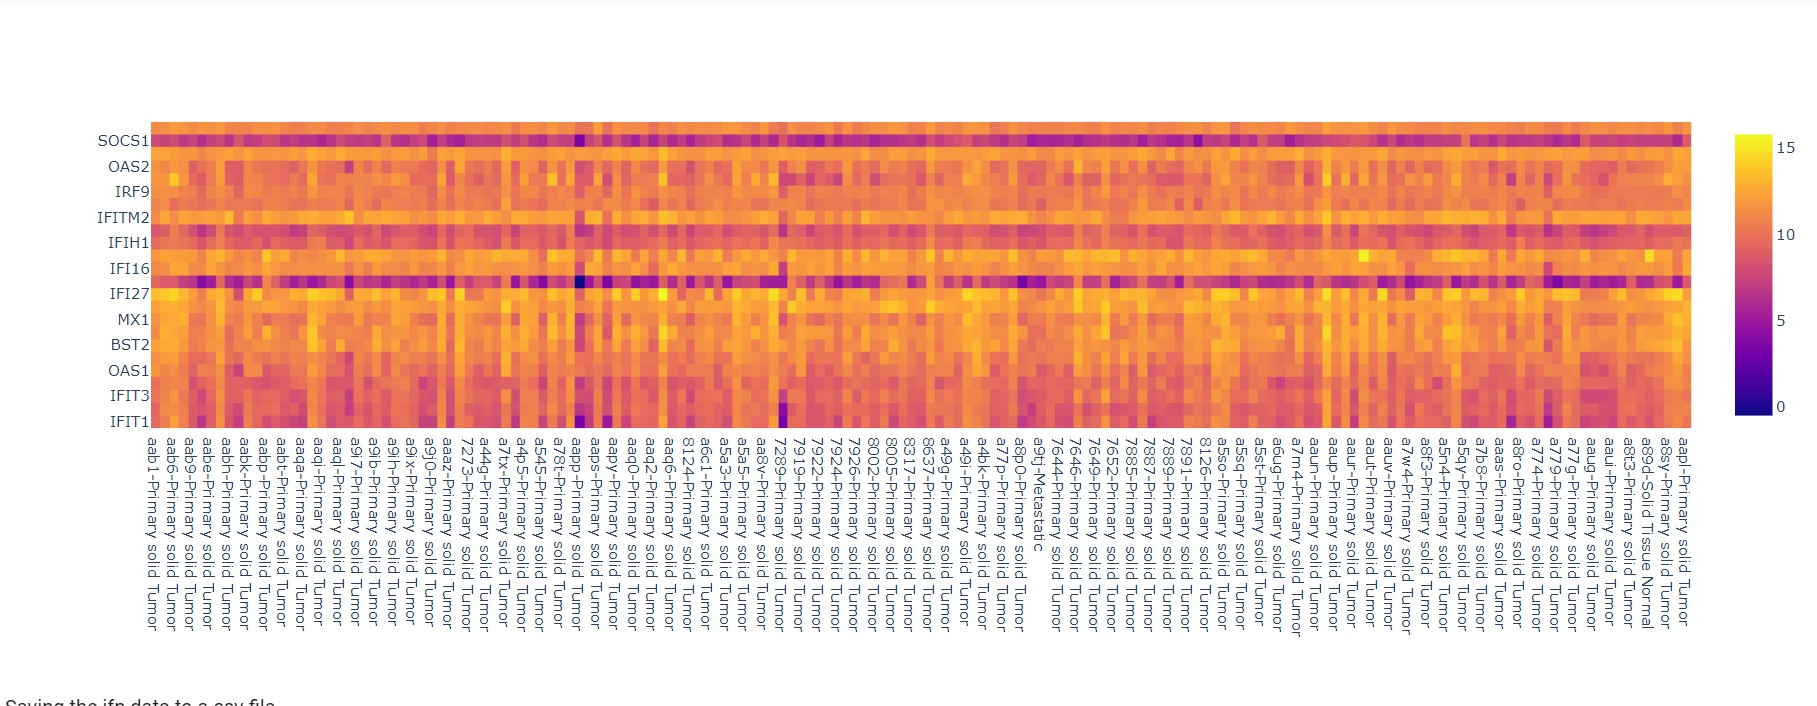

Saving the ifn data to a csv file

In [ ]:
ifn_df.to_csv('ifn_df.csv')

### Using the gsva python package
To get the score

In [ ]:
ifn_df.head()

cid    aab1-Primary solid Tumor  ...  aapl-Primary solid Tumor
rid                              ...                          
IFIT1                       9.5  ...                      10.2
IFI44                       9.4  ...                      10.9
IFIT3                      10.0  ...                      10.2
MX2                         9.8  ...                      10.9
OAS1                       11.7  ...                      10.7

[5 rows x 167 columns]

In [ ]:
sample_dis = []
sample_name = []
for i in range(len(arr)):
  sample_dis.append("sample")
  sample_name.append("ELUCI_"+arr[i])
gene_set = pd.DataFrame({"description":sample_dis,"member":arr,"name":sample_name})

In [ ]:
gene_set.head()

description member         name
0      sample  IFIT1  ELUCI_IFIT1
1      sample  IFI44  ELUCI_IFI44
2      sample  IFIT3  ELUCI_IFIT3
3      sample    MX2    ELUCI_MX2
4      sample   OAS1   ELUCI_OAS1

In [ ]:
pathways_df = gsva(ifn_df,gene_set,tempdir="./tmp")

In [ ]:
pathways_df

array([[-1.0254484 , -0.54580337,  0.4218912 , ..., -0.5101048 ,
        -0.03544304, -0.8508574 ],
       [-1.1016431 , -0.12096153, -0.2861782 , ..., -0.3770335 ,
        -0.17721607, -0.28135946],
       [-0.64447683, -0.3333825 , -0.00295003, ..., -0.44356912,
        -0.2244739 , -0.8508574 ],
       ...,
       [ 1.1079925 ,  0.72872156,  0.28027746, ...,  0.22178456,
         0.6734217 ,  0.77628   ],
       [-2.3969464 , -2.7408183 , -2.622807  , ..., -2.5727007 ,
        -2.4455833 , -1.9898533 ],
       [ 0.26985478,  0.0206522 ,  0.28027746, ...,  0.42139077,
        -0.17721607,  0.36949566]], dtype=float32)

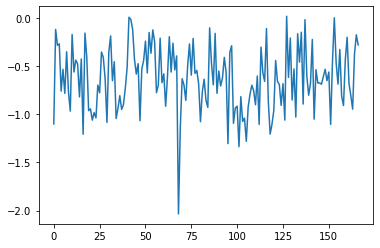

In [ ]:
plt.plot(pathways_df[1])

### B. By keeping the missing values

In [ ]:
def findMissingVals(data):
  missing_val_count = data.isnull().sum().sum()
  print("Total missing Values in data "+str(missing_val_count))

In [ ]:
findMissingVals(data)

Total missing Values in data 134954


>there are a lot of missing values we need to replace these value for good results

In [ ]:
def replaceMissingValues(data):
  imputer = SimpleImputer()
  imputed_data = pd.DataFrame(imputer.fit_transform(data))
  imputed_data.columns = data.columns
  imputed_data.index = data.index
  return imputed_data

In [ ]:
imputed_data = replaceMissingValues(data)

>set the participent id

In [ ]:
imputed_data = imputed_data.rename(columns=col_meta_data["participant_id"]).T
imputed_data.head()

rid   SLC35E2  A1BG  A1CF     A2BP1  ...   ZYX  ZZEF1  ZZZ3  psiTPTE22
cid                                  ...                              
aab1     7.45   6.4   4.7 -1.000000  ...  12.9   10.1   9.3        5.5
aab4     8.10   5.8   5.7  1.100000  ...  12.4    9.8   8.9        4.5
aab6     7.20   6.4   3.0  7.577068  ...  13.5    9.8   9.2        4.7
aab8     8.00   5.8   5.1  7.728812  ...  12.5    9.7   9.3        6.4
aab9     7.65   6.7   4.4  0.100000  ...  13.0   10.1   9.2        4.9

[5 rows x 18465 columns]

>now lets merge both the data to get a final dataset

In [ ]:
cols_merge = ['sample_type', 'mRNAseq_cluster','adenocarcinoma_invasion', 'vital_status', 'maximum_tumor_dimension', 'pathologic_stage', 'pathologic_m', 'pathologic_n', 'pathologic_t']

In [ ]:
col_meta_data = col_meta_data.set_index('participant_id')
for cols in cols_merge:
  imputed_data[cols] = col_meta_data[cols]

In [ ]:
imputed_data.head()

rid   SLC35E2  A1BG  A1CF  ...  pathologic_m  pathologic_n  pathologic_t
cid                        ...                                          
aab1     7.45   6.4   4.7  ...            m0            n1            t3
aab4     8.10   5.8   5.7  ...            m0            n1            t2
aab6     7.20   6.4   3.0  ...            m0            n0            t3
aab8     8.00   5.8   5.1  ...            m0            n1            t3
aab9     7.65   6.7   4.4  ...            m0            n1            t3

[5 rows x 18474 columns]

In [ ]:
le = LabelEncoder()

In [ ]:
for i in dtypes.iteritems():
  if i[1]=='object':
    col_name = i[0]
    imputed_data[col_name] = imputed_data[col_name].astype('|S')
    imputed_data[col_name] = le.fit_transform(imputed_data[col_name])

In [ ]:
imputed_data.head()

rid   SLC35E2  A1BG  A1CF  ...  pathologic_m  pathologic_n  pathologic_t
cid                        ...                                          
aab1     7.45   6.4   4.7  ...             0             1             3
aab4     8.10   5.8   5.7  ...             0             1             2
aab6     7.20   6.4   3.0  ...             0             0             3
aab8     8.00   5.8   5.1  ...             0             1             3
aab9     7.65   6.7   4.4  ...             0             1             3

[5 rows x 18474 columns]

>Calculating the variance of the data with missing values filled with imputed values

In [ ]:
std = scaler.fit_transform(imputed_data.drop(columns=cols_merge))

In [ ]:
std

array([[-7.5770253e-01,  3.0382883e-03, -9.7996496e-02, ...,
        -1.3685629e-01,  2.1507382e-01,  3.7639171e-01],
       [ 3.3015215e-01, -5.5295122e-01,  3.9742005e-01, ...,
        -6.5502512e-01, -7.1100837e-01, -4.0602025e-01],
       [-1.1761079e+00,  3.0382883e-03, -9.4020450e-01, ...,
        -6.5502512e-01, -1.6447276e-02, -2.4953800e-01],
       ...,
       [-9.2506450e-01,  1.3930123e+00, -1.8319544e+00, ...,
        -6.5502512e-01, -1.4055673e+00,  6.8935651e-01],
       [-1.1761079e+00, -3.6762154e-01,  1.0869540e-03, ...,
        -1.0004705e+00, -1.8686094e+00, -2.0490851e+00],
       [ 1.9200919e+00,  4.6636298e-01, -1.4356211e+00, ...,
         1.2449251e+00,  4.4659269e-01,  2.9815057e-01]], dtype=float32)

In [ ]:
#Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y = pca.fit_transform(std)

Explained Variance Ratio--
[0.1357848  0.10518718]
################################


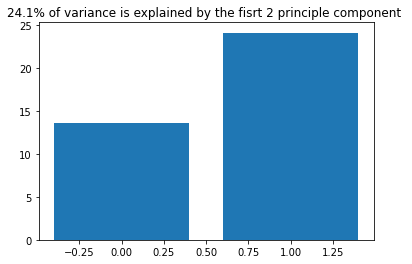

In [ ]:
variancePCAPlot(pca,2)

Text(0, 0.5, 'PC2')

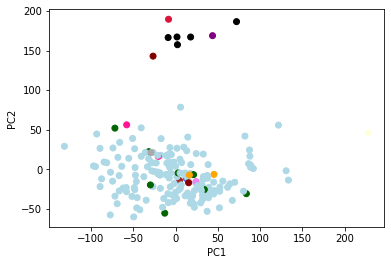

In [ ]:
plt.scatter(y[:,0], y[:,1],c=labels)
plt.xlabel("PC1")
plt.ylabel("PC2")

From this plot we can see that there are less outliers in the data and we can clearly seperate both the clusters.

In [ ]:
pca_df2 = pd.DataFrame(y, columns=['PC1', 'PC2'], index=new_data.columns.values)
pca_df2.head()

PC1        PC2
aab1-Primary solid Tumor  24.202921 -16.855980
aab4-Primary solid Tumor   4.754332 -14.106700
aab6-Primary solid Tumor  32.163017 -24.703453
aab8-Primary solid Tumor   4.316135 -25.736286
aab9-Primary solid Tumor   0.031906   3.829056

In [ ]:
neuroendocrine_tumors = pca_df2[(pca_df2['PC1'] < -100) | (pca_df2['PC1'] > 100) | (pca_df2['PC2'] > 50)].index
print(neuroendocrine_tumors)
print("Number of Neuroendocrine Tumors:"+str(len(neuroendocrine_tumors)))

Index(['aabv-Primary solid Tumor', 'aaqm-Primary solid Tumor',
       'a9ij-Primary solid Tumor', 'a9il-Primary solid Tumor',
       'a9in-Primary solid Tumor', 'a9io-Primary solid Tumor',
       'a9ir-Primary solid Tumor', 'a9is-Primary solid Tumor',
       'a9iv-Primary solid Tumor', '6880-Primary solid Tumor',
       'a45n-Solid Tissue Normal', 'a7ol-Primary solid Tumor',
       'a7op-Primary solid Tumor', '8519-Primary solid Tumor',
       '7897-Primary solid Tumor', 'a75w-Primary solid Tumor',
       'aauh-Primary solid Tumor'],
      dtype='object')
Number of Neuroendocrine Tumors:17


In [ ]:
arr = []
for i in ifn_data.values:
  v = i.tolist()
  arr.append(v[0])

In [ ]:
imputed_data_t = imputed_data.T

In [ ]:
ifn_df2 = imputed_data_t.loc[arr]

In [ ]:
configure_plotly_browser_state()
pyo.init_notebook_mode()

fig = go.Figure(data=go.Heatmap(
                   z=ifn_df2.values,
                   x=ifn_df2.columns,
                   y=ifn_df2.index,
                   hoverongaps = False))
fig.show()

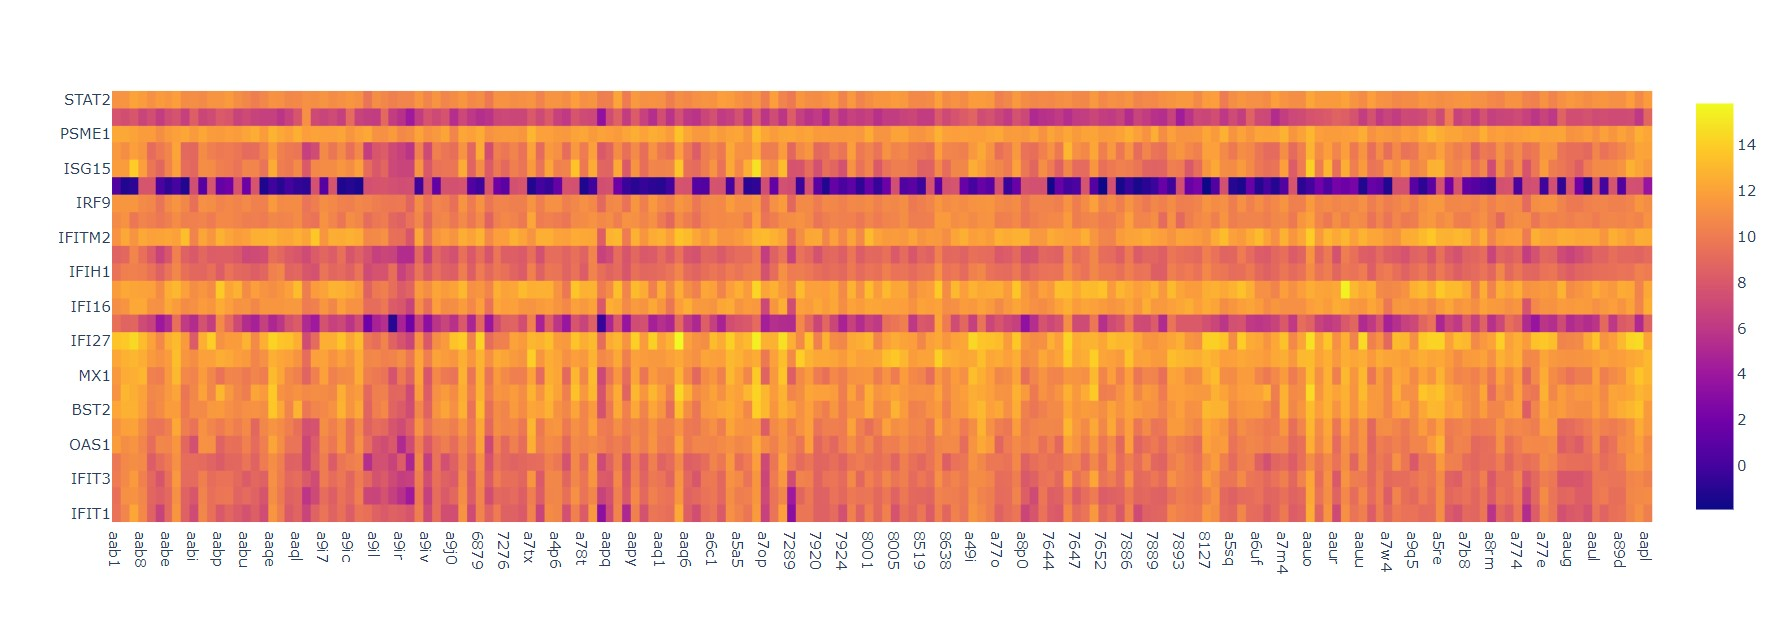

In [ ]:
ifn_df2.to_csv('ifn_df2.csv')

### Generation of scores for IFN signatures

In [ ]:
ifn_df2.shape

(25, 183)

In [ ]:
sample_dis = []
sample_name = []
for i in range(25):
  sample_dis.append("sample")
  sample_name.append("ELUCI_"+arr[i])
gene_set = pd.DataFrame({"description":sample_dis,"member":arr,"name":sample_name})

In [ ]:
gene_set.head()

description member         name
0      sample  IFIT1  ELUCI_IFIT1
1      sample  IFI44  ELUCI_IFI44
2      sample  IFIT3  ELUCI_IFIT3
3      sample    MX2    ELUCI_MX2
4      sample   OAS1   ELUCI_OAS1

In [ ]:
ifn_df2.head()

cid    aab1  aab4  aab6  aab8  aab9  aaba  ...  a8t5  a89d  a89d  a8sy  a8lh  aapl
rid                                        ...                                    
IFIT1   9.5  10.5  12.2  10.7   8.6   6.7  ...   9.4   8.4   9.5  10.4  11.1  10.2
IFI44   9.4  11.1  11.2  10.6   8.8   8.4  ...   9.3   8.9   9.3  10.6  10.8  10.9
IFIT3  10.0  10.8  11.6  10.3   9.0   7.8  ...   9.6   9.1   9.6  10.5  10.7  10.2
MX2     9.8  10.7  11.0  10.8   8.3   9.2  ...   9.7   9.3  10.0  11.4  11.5  10.9
OAS1   11.7  11.0  11.3  10.5   9.2  10.6  ...   9.5  10.5  10.9  11.1  11.9  10.7

[5 rows x 183 columns]

In [ ]:
pathways_df = gsva(ifn_df2,gene_set,tempdir="./tmp")

In [ ]:
pathways_df

array([[-0.38820608, -0.09685409,  0.39042006, ..., -0.38019869,
         0.03397737, -0.39013015],
       [-0.42985926,  0.11679482,  0.03289246, ..., -0.25787662,
        -0.1024341 , -0.0230724 ],
       [-0.179941  ,  0.00997036,  0.17590371, ..., -0.31903765,
        -0.14790474, -0.39013015],
       ...,
       [ 0.77807845,  0.54409229,  0.31891461, ...,  0.29257037,
         0.7160343 ,  0.65860657],
       [-1.13796046, -1.20070603, -1.1469485 , ..., -2.27618321,
        -2.28501637, -1.12424566],
       [ 0.31989511,  0.18801101,  0.31891461, ...,  0.47605289,
        -0.1024341 ,  0.39642239]])

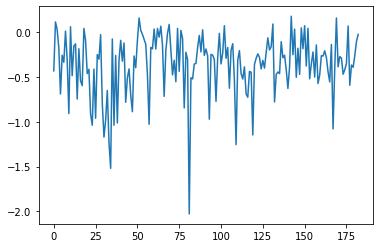

In [ ]:
plt.plot(pathways_df[1])

### Calculating Rank by CDF of the gene sets

In [ ]:
new_data = replaceMissingValues(data)

In [ ]:
new_data.head()

cid      aab1-Primary solid Tumor  ...  aapl-Primary solid Tumor
rid                                ...                          
SLC35E2                      7.45  ...                  9.050000
A1BG                         6.40  ...                  6.900000
A1CF                         4.70  ...                  2.000000
A2BP1                       -1.00  ...                  7.660113
A2LD1                        7.50  ...                  6.700000

[5 rows x 183 columns]

In [ ]:
new_data.shape

(18465, 183)

>the data has 18465 genes and 183 samples

In [ ]:
import scipy
def calCDFAndRank(data):
  norm_cdf = scipy.stats.norm.cdf(data.values)
  _,id = np.unique(norm_cdf,return_inverse=True)
  out = (id.max() - id + 1).reshape(norm_cdf.shape)
  return out

In [ ]:
for col in new_data:
  new_data[col] = calCDFAndRank(new_data[col])

In [ ]:
new_data.head()

cid      aab1-Primary solid Tumor  ...  aapl-Primary solid Tumor
rid                                ...                          
SLC35E2                        10  ...                         1
A1BG                           21  ...                        16
A1CF                           38  ...                        65
A2BP1                          88  ...                         8
A2LD1                           9  ...                        18

[5 rows x 183 columns]

## TSNE Plot of the same

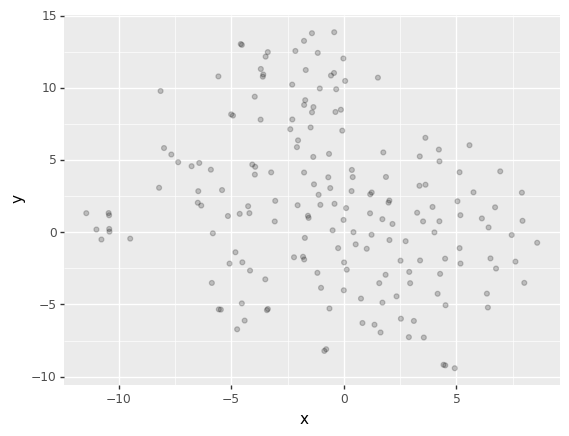

<ggplot: (-9223363260949080597)>

In [ ]:
XV = TSNE(n_components=2).fit_transform(std)
df = pd.DataFrame(XV).rename(columns={0:'x',1:'y'})
(ggplot(df,aes(x='x',y='y'))
 + geom_point(alpha=0.2)
)